In [16]:
#install the following package
#!pip install  torch numpy scikit-learn h5py PyWavelets

# Step 1: loading mat file
import numpy as np
import h5py
from bcgunet import bcgunet
import glob
from os.path import *

ffs = glob.glob(r'/NFS/tyhuang/fhlinXBCG/noscan/*/analysis/eyeclose_*.mat')
result_obs = []
result_unet = []
result_eeg = []
for close_f in ffs:
    open_f = close_f.replace('close', 'open')

    if not isfile(open_f):
        continue

    f = h5py.File(close_f , 'r')
    ECG = np.array(f['ECG']).flatten()
    EEG = np.array(f['EEG_before_bcg']).T
    EEG_OBS = np.array(f['EEG']).T
    EEG_unet = bcgunet.run(EEG, ECG)
    psd_obs_close = bcgunet.get_psd(EEG_OBS[:, ::10], sfreq=500)
    psd_unet_close = bcgunet.get_psd(EEG_unet[:, ::10], sfreq=500)
    psd_eeg_close= bcgunet.get_psd(EEG[:, ::10], sfreq=500)

    f = h5py.File(open_f , 'r')
    ECG = np.array(f['ECG']).flatten()
    EEG = np.array(f['EEG_before_bcg']).T
    EEG_OBS = np.array(f['EEG']).T
    EEG_unet = bcgunet.run(EEG, ECG)
    psd_obs_open = bcgunet.get_psd(EEG_OBS[:, ::10], sfreq=500)
    psd_unet_open = bcgunet.get_psd(EEG_unet[:, ::10], sfreq=500)
    psd_eeg_open = bcgunet.get_psd(EEG[:, ::10], sfreq=500)

    result_obs.append(psd_obs_close / psd_obs_open)
    result_unet.append(psd_unet_close / psd_unet_open)
    result_eeg.append(psd_eeg_close / psd_eeg_open)



100%|███████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 67.55it/s]


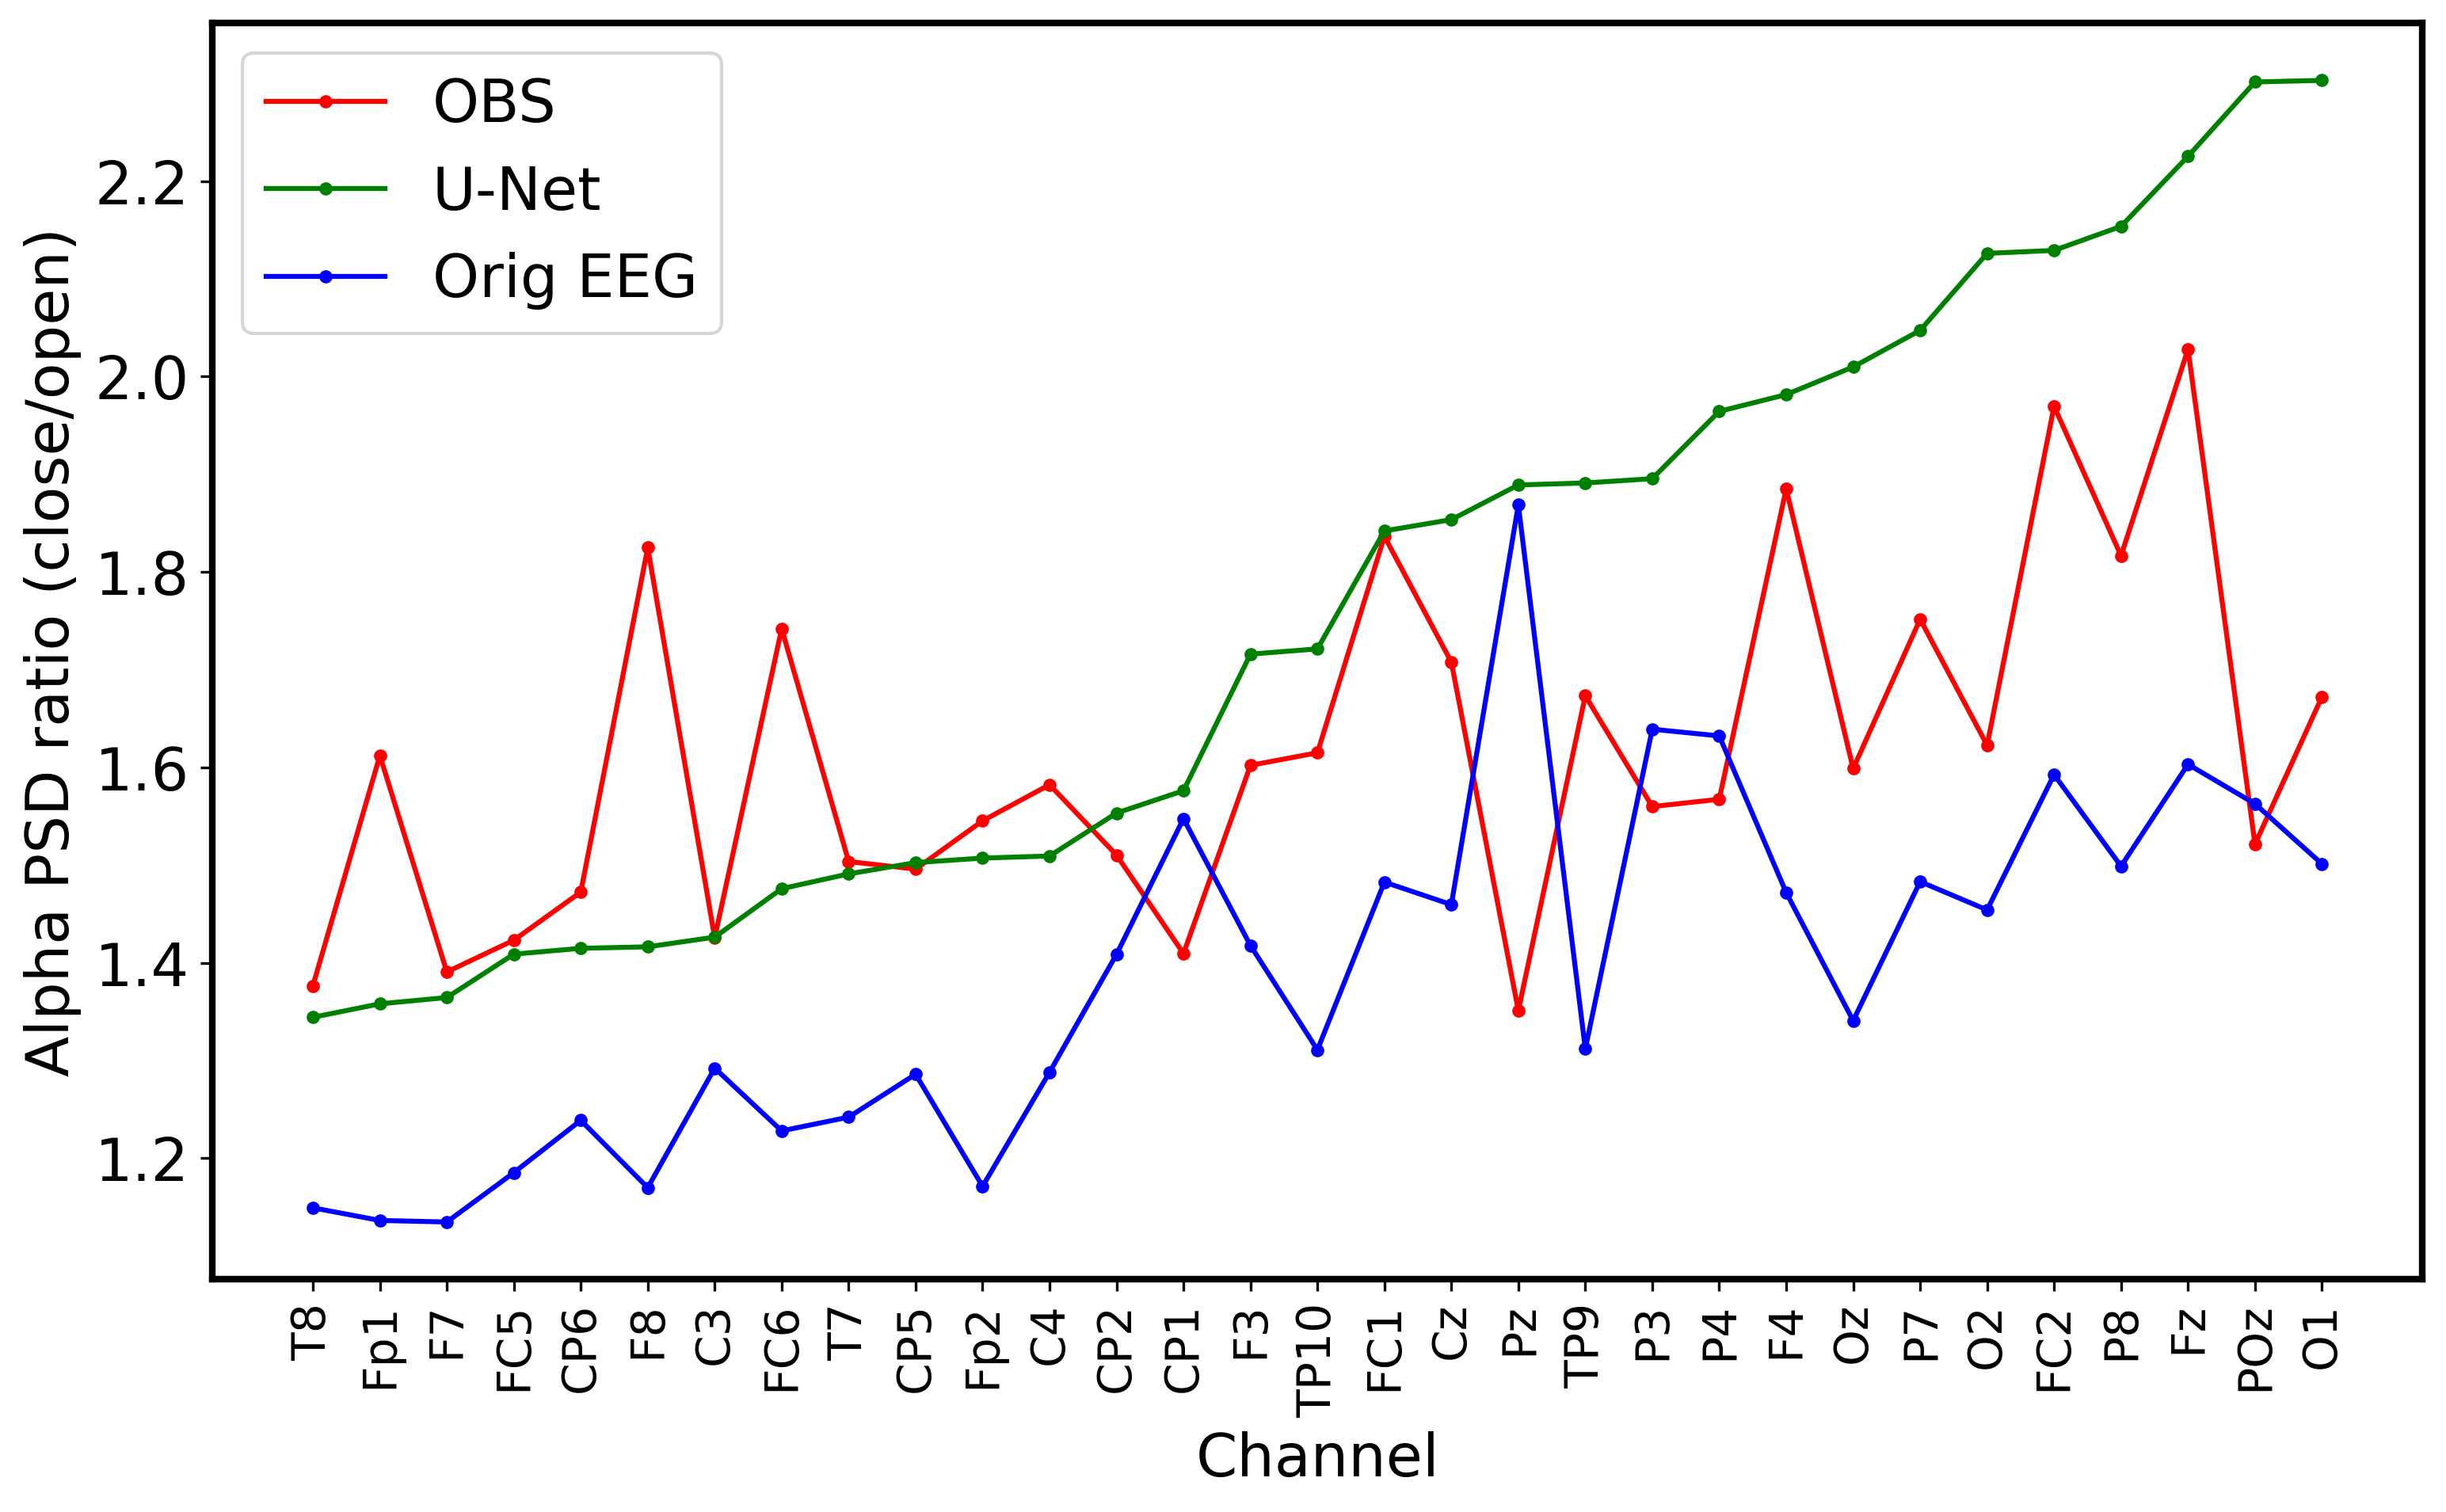

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7), dpi=300)
indx = np.argsort(np.mean(result_unet, axis=0).flatten())

plt.plot(np.mean(result_obs, axis=0)[indx], 'r.-', label='OBS')
plt.plot(np.mean(result_unet, axis=0)[indx] , 'g.-', label='U-Net')
plt.plot(np.mean(result_eeg, axis=0)[indx], 'b.-', label='Orig EEG' )

label = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1',
         'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz',
         'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6',
         'CP5', 'CP6', 'TP9', 'TP10', 'POz']
label = [label[ii] for ii in indx]
plt.xlabel('Channel')
plt.ylabel('Alpha PSD ratio (close/open)')
plt.xticks(np.arange(31), label, fontsize=14, rotation=90)

plt.legend()